# Data compression for binary neutron star (BNS) waveforms
The goal of this notebook is to explore BNS waveforms, and how they can be cleverly
compressed by using an adaptive resolution in frequency space.

In [1]:
import numpy as np

np.random.seed(1)
import matplotlib.pyplot as plt
from dingo.gw.domains import build_domain, FrequencyDomain
from dingo.gw.prior import build_prior_with_defaults
from dingo.gw.waveform_generator import WaveformGenerator
from dingo.gw.dataset.generate_dataset import generate_parameters_and_polarizations

from multibanded_frequency_domain import MultibandedFrequencyDomain
from multibanding_utils import (
    get_periods,
    number_of_zero_crossings,
    get_decimation_bands_adaptive,
    get_decimation_bands_from_chirp_mass,
    duration_LO,
)
from heterodyning import factor_fiducial_waveform, change_heterodyning

We start by setting up a uniform frequency domain and a prior, to generate a waveform
dataset with BNS polarizations.

In [2]:
# build domain
uniform_frequency_domain_settings = {
    "type": "FrequencyDomain",
    "f_min": 20,
    "f_max": 1024,
    "delta_f": 1 / 256,
    "window_factor": 1.0,
}
original_domain = build_domain(uniform_frequency_domain_settings)

# build prior
intrinsic_prior_settings = {
    "mass_1": "bilby.core.prior.Constraint(minimum=1.0, maximum=2.5)",
    "mass_2": "bilby.core.prior.Constraint(minimum=1.0, maximum=2.5)",
    "chirp_mass": "bilby.gw.prior.UniformInComponentsChirpMass(minimum=1.0, maximum=2.0)",
    "mass_ratio": "bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1.0)",
    "phase": "default",
    "a_1": "bilby.core.prior.Uniform(minimum=0.0, maximum=0.99)",
    "a_2": "bilby.core.prior.Uniform(minimum=0.0, maximum=0.99)",
    "tilt_1": "default",
    "tilt_2": "default",
    "phi_12": "default",
    "phi_jl": "default",
    "theta_jn": "default",
    "luminosity_distance": "100.0",
    "geocent_time": "0.0",
}
prior = build_prior_with_defaults(intrinsic_prior_settings)

# build waveform generator
wfg_settings = {"approximant": "IMRPhenomPv2_NRTidal", "f_ref": 10}
num_samples = 100
num_processes = 0

waveform_generator = WaveformGenerator(domain=original_domain, **wfg_settings)

parameters, polarizations = generate_parameters_and_polarizations(
    waveform_generator, prior, num_samples, num_processes
)

Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.
Generating dataset of size 100


## Heterodyning
BNS waveforms are very long. E.g., for a GW170817-like chirp mass of $M_\text{c} = 1.1975\,\text{M}_\odot$,
the leading order duration of the chirp at $f=20\,\text{Hz}$ is $\approx 162\,\text{s}$.

In [3]:
duration_LO(1.1975, frequency=20)

162.57058421495788

We therefore need an extremely high resolution in frequency domain, such as $\Delta_f = 1/256\,\text{Hz}$.
This resolution is required to capture the rapidly evolving phase evolution. However,
the leading order the phase evolution can be computed from the chirp mass. By
subtracting the leading order ($M_\text{c}$-dependent) phase from the waveform, we
obtain waveforms that oscillate much slower. This subtraction is called *heterodyning*,
and it is implemented in `factor_fiducial_waveform`.

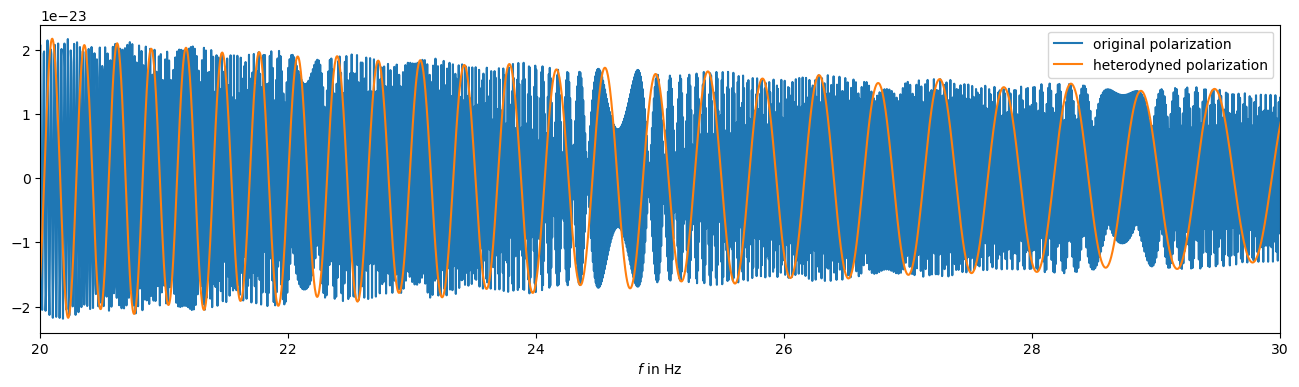

In [4]:
hp = polarizations["h_plus"]
chirp_mass = np.array(parameters["chirp_mass"])
hp_het = factor_fiducial_waveform(hp, original_domain, chirp_mass)
fig = plt.figure()
fig.set_size_inches((16, 4))
plt.plot(original_domain(), hp[0].real, label="original polarization")
plt.plot(original_domain(), hp_het[0].real, label="heterodyned polarization")
plt.xlim((20,30))
plt.xlabel("$f$ in Hz")
plt.legend()
plt.show()

We indeed observe a much slower oscillation behavior. This is also reflected in the
total number of oscillations of the waveform.

In [5]:
num_osc_original = number_of_zero_crossings(hp.real[..., original_domain.min_idx:])
num_osc_het = number_of_zero_crossings(hp_het.real[..., original_domain.min_idx:])
print("Number of oscillations")
print(f"Original waveform     {num_osc_original[:10]}")
print(f"Heterodyned waveform  {num_osc_het[:10]}")

Number of oscillations
Original waveform     [4594 3819 2962 2759 2393 3537 2733 2370 3835 4382]
Heterodyned waveform  [116  85  65  50  48  72  66  59  78 107]


So heterodyning clearly simplifies the phase evolution of the waveforms, reducing the
number of oscillations by a factor of almost 100. As we will show later, this also
enables us to build a very tight SVD basis for BNS waveforms.

## Adaptive Multibanding
While heterodyining simplifies the waveforms, we still have very high dimensional data.

In [6]:
print(hp.shape, hp_het.shape)

(100, 262145) (100, 262145)


The next step will thus be to reduce the number of frequency bins by decimation. The
key insight here is that the resolution does not need to be constant throughout the
frequency range, but instead we can use a resolution that is adapted to the phase
evolution. The figure below shows how the waveform oscillates much faster at low
frequencies.

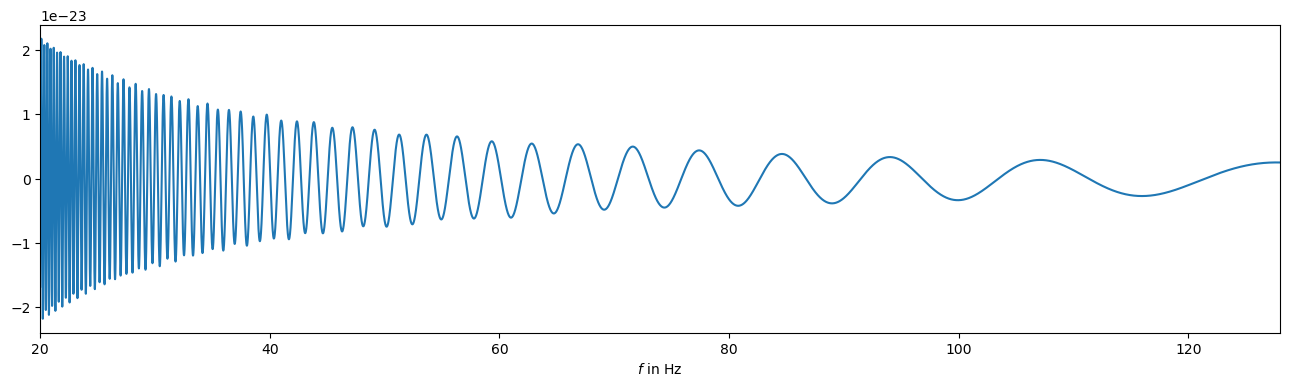

In [7]:
fig = plt.figure()
fig.set_size_inches((16, 4))
plt.plot(original_domain(), hp_het[0].real)
plt.xlim((20, 128))
plt.xlabel("$f$ in Hz")
plt.show()

The figure below visualizes the minimal oscillation period of the waveforms as a
function of the frequency.

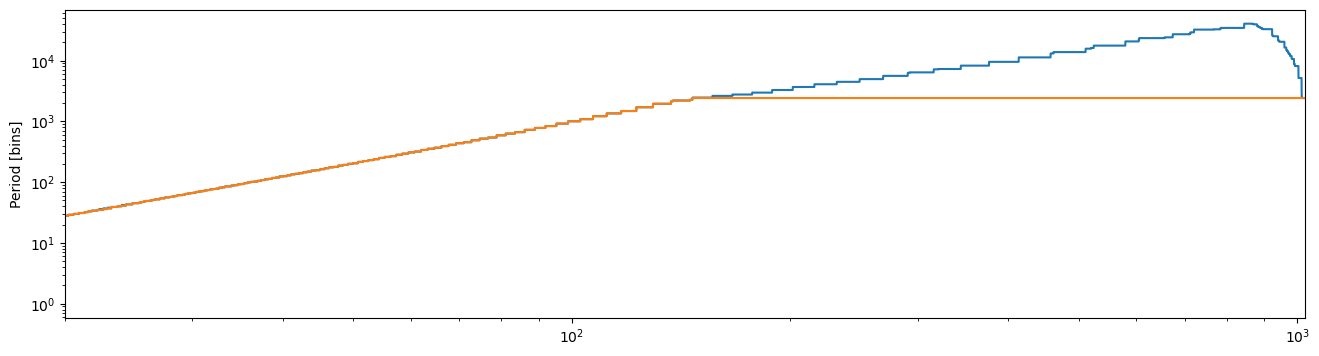

In [8]:
x = original_domain()
fig = plt.figure()
fig.set_size_inches((16, 4))
plt.plot(x, np.min(get_periods(hp_het.real, upper_bound_for_monotonicity=False), axis=0))
plt.plot(x, np.min(get_periods(hp_het.real, upper_bound_for_monotonicity=True), axis=0))
plt.yscale("log")
plt.ylabel("f in Hz")
plt.xlim(original_domain.f_min, original_domain.f_max)
plt.xscale("log")
plt.ylabel("Period [bins]")
plt.show()

We now wish to capture the waveform data with frequency bans that are adapted to these
requirements. We want to have at least 8 bins per period, which determines the
frequency of the lowest band. We then move along the frequency axis and double
$\Delta f_\text{b}$ whenever this is possible while still having $\geq 8$ bins per
period. This is implemented with the function `get_decimation_bands_adaptive`.

In [9]:
bands = get_decimation_bands_adaptive(
    original_domain, hp_het, min_num_bins_per_period = 8, delta_f_max = 2.0
)
for band in bands: print(band)

[20.001953125, 21.541015625, 0.0078125]
[21.552734375, 29.552734375, 0.015625]
[29.576171875, 40.513671875, 0.03125]
[40.560546875, 55.248046875, 0.0625]
[55.341796875, 74.591796875, 0.125]
[74.779296875, 102.779296875, 0.25]
[103.154296875, 137.154296875, 0.5]
[137.904296875, 1022.904296875, 1.0]


These bands can then be used to instantiate a MultibandedFrequencyDomain object.

In [10]:
mfd = MultibandedFrequencyDomain(bands, original_domain)
print(
    f"With adaptive multibanding and heterodyining, we could reduce the number "
    f"of frequency bins from {len(original_domain)} to {len(mfd)}."
)

With adaptive multibanding and heterodyining, we could reduce the number of frequency bins from 262145 to 2521.


Going from data in the original (uniform) frequency domain to the new multibanded
domain works via the decimation method. This averages nearby bins. The funcion
`get_decimation_bands_adaptive` sets the bands up in a way that allows for efficient
decimation. This is implemented as a method of `MultibandedFrequencyDomain`.

Note that with decimation we lose information, since we average nearby frequency bins.
However, we made sure to have at a certain minimum number of bins per oscillation
(here: 8), which ensures that the waveform does not change to rapidly. If the waveform
is approximately constant within the decimation window, we don't lose information with
decimation.

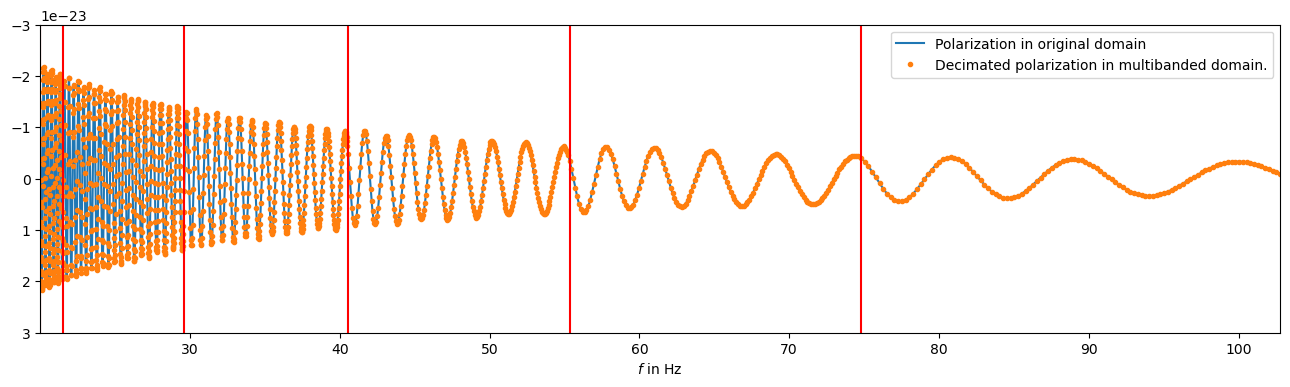

In [11]:
hp_het_dec = mfd.decimate(hp_het)
fig = plt.figure()
fig.set_size_inches((16, 4))
plt.plot(original_domain(), hp_het[0].real, label="Polarization in original domain")
plt.plot(
    mfd(), hp_het_dec[0].real, '.', label="Decimated polarization in multibanded domain."
)
plt.xlabel("$f$ in Hz")
start_band = 0
plt.xlim((mfd._f_min_bands[start_band],mfd._f_max_bands[start_band+5]))
plt.ylim(3e-23, -3e-23)
plt.vlines(mfd._f_min_bands, -1, 1, color="red")
plt.legend()
plt.show()

Below, we plot the period as a function of bin number. We observe that the period is
indeed $\geq 8$ bins as desired. Whenever a new band is entered, the period drops by a
factor of 2, and then slowly increases again.

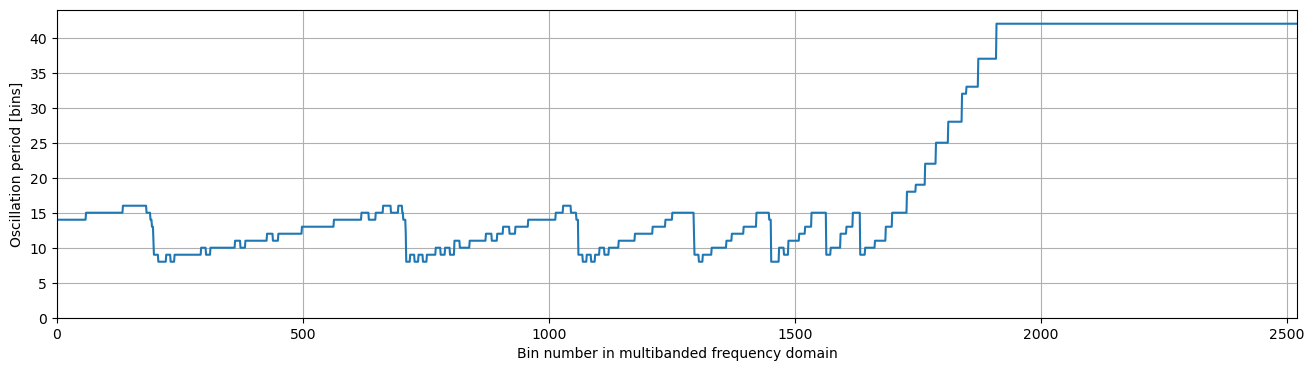

In [12]:
fig = plt.figure()
fig.set_size_inches((16, 4))
y = np.min(get_periods(hp_het_dec.real), axis=0)
plt.plot(y)
plt.xlabel("Bin number in multibanded frequency domain")
plt.ylabel("Oscillation period [bins]")
plt.ylim((0, np.max(y) + 2))
plt.xlim((0, len(y)))
plt.grid()
plt.show()

### Non-adaptive multibanding based on chirp mass

Originally, multibanding was developed for non-heterodyned waveforms. The leading order
duration of the chirp determines the minimum required resolution to capture the
non-heterodyned waveform as a function of frequency.

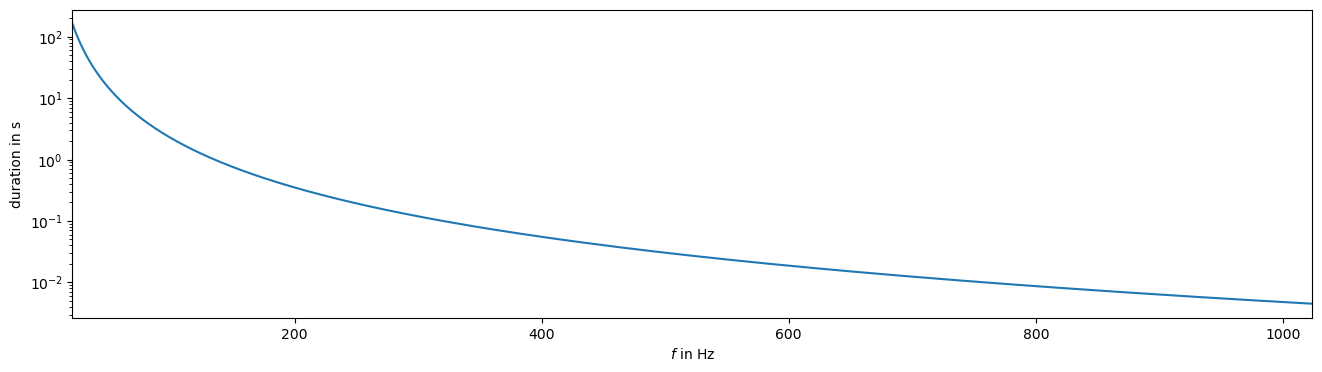

In [13]:
x = original_domain()[original_domain.min_idx:]
y = duration_LO(1.1975, x)
fig = plt.figure()
fig.set_size_inches((16, 4))
plt.plot(x, y)
plt.xlim((original_domain.f_min, original_domain.f_max))
plt.yscale("log")
plt.xlabel("$f$ in Hz")
plt.ylabel("duration in s")
plt.show()

Based on this, we can again extract frequency bands, which is implemented with
`get_decimation_bands_from_chirp_mass`. The resolution should be sufficient to capture
even non-heterodyned waveforms. Since we work with heterodyned waveforms, we can likely
get away with a smaller resolution. This can be adjusted with the `alpha` parameter in
`get_decimation_bands_from_chirp_mass`.

In [14]:
bands = get_decimation_bands_from_chirp_mass(
    original_domain, 1.0, alpha = 8, delta_f_max = 2.0
)
for band in bands: print(band)
mfd_chirp = MultibandedFrequencyDomain(bands, original_domain)
print(
    f"With multibanding, we could reduce the number "
    f"of frequency bins from {len(original_domain)} to {len(mfd_chirp)}."
)

[20.013671875, 116.451171875, 0.03125]
[116.498046875, 150.998046875, 0.0625]
[151.091796875, 195.841796875, 0.125]
[196.029296875, 253.779296875, 0.25]
[254.154296875, 329.154296875, 0.5]
[329.904296875, 426.904296875, 1.0]
[428.404296875, 1022.404296875, 2.0]
With multibanding, we could reduce the number of frequency bins from 262145 to 4778.


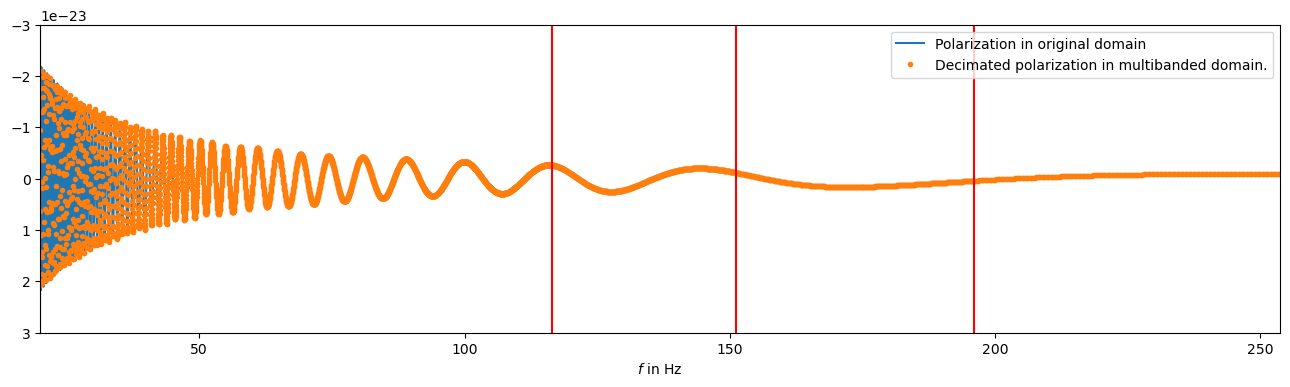

In [15]:
hp_het_dec = mfd_chirp.decimate(hp_het)
fig = plt.figure()
fig.set_size_inches((16, 4))
plt.plot(original_domain(), hp_het[0].real, label="Polarization in original domain")
plt.plot(
    mfd_chirp(), hp_het_dec[0].real, '.', label="Decimated polarization in multibanded domain."
)
plt.xlabel("$f$ in Hz")
start_band = 0
plt.xlim((mfd_chirp._f_min_bands[start_band],mfd_chirp._f_max_bands[start_band+3]))
plt.ylim(3e-23, -3e-23)
plt.vlines(mfd_chirp._f_min_bands, -1, 1, color="red")
plt.legend()
plt.show()

However, this method is not ideal. Visualizing the number of bins per period reveals
that the resolution varies a lot throughout the frequency range. The adaptive method
above indeed provides a more homogeneous coverage of the oscillations.

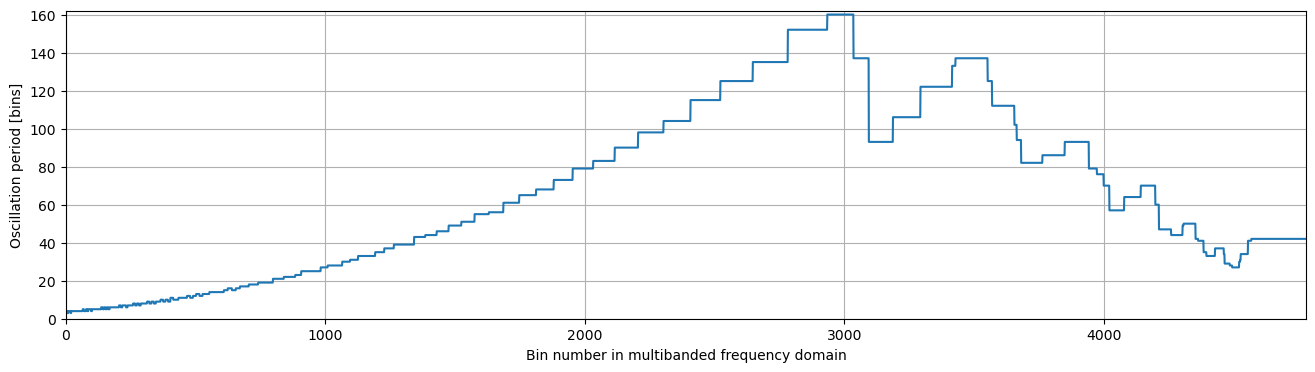

In [16]:
fig = plt.figure()
fig.set_size_inches((16, 4))
y = np.min(get_periods(hp_het_dec.real), axis=0)
plt.plot(y)
plt.xlabel("Bin number in multibanded frequency domain")
plt.ylabel("Oscillation period [bins]")
plt.ylim((0, np.max(y) + 2))
plt.xlim((0, len(y)))
plt.grid()
plt.show()